In [16]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2

include("./read_lidar.jl")
using .read_lidar
# using MAT

using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar`


In [17]:
# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

"bin average y in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"find indices i such that each xl[i] is the first >= xs."
function findindices(xs, xl)
    # xs needles define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average within +-half points of the index of xl"
function indavg(xl, ind; half=5)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx-half) : min(length(xl),idx+half)
        xm[i] = sum(Float64.(xl[ii])) / (2*half+1)
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# displacements with no adjustment for tilting into the horizontal wind 
# U, V vary slowly; pitch,roll,w vary fast
# there are nt*(nt-1)/2 ~ O(nt^2) outputs, so correct stuff first

"return the coherent component of signal1 and signal2"
function coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Inverse Fourier Transform to get the time-domain signals
    coherent_signal1 = real(ifft(coherent_part_S1))
    coherent_signal2 = real(ifft(coherent_part_S2))
    
    return coherent_signal1, coherent_signal2
end

"remove the coherent component of signal1 and signal2"
function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Remove the coherent part
    clean_S1 = S1 .- coherent_part_S1
    clean_S2 = S2 .- coherent_part_S2
    
    # Inverse Fourier Transform to get the time-domain signals
    clean_signal1 = real(ifft(clean_S1))
    clean_signal2 = real(ifft(clean_S2))
    
    return clean_signal1, clean_signal2
end

remove_coherent_component

In [18]:
# functions for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)


(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(998, 1), CartesianIndex(999, 1)], CartesianIndex{2}[CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1), CartesianIndex(11, 1)  …  CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(1000, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [19]:
# displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

## example load data sets

In [20]:
# functions to refine synchronize the lidar clock

"""
find_time_shift(mdv, heave) positive result means mdv clock is fast.
sync by subtracting this lag (in 1020 millisecods) from stare_dt.
"""
function get_time_shift(mdv, heave)
    # filter to make xcorr work better
    xc = xcorr(hp(mdv[:]), hp(heave[:]))
    # plot(-(length(mdv)-1):length(mdv)-1, xc )
    return argmax(xc) - length(mdv)
end

# broken:
# """
# Returns the decremented stare_dt by time offset subtracted from the lidar clock.
# """
# function sync_lidar_clock(stare_dt, mdv, heave)
#     lidar_clock_fast_by = Millisecond( 1020*get_time_shift(mdv[:],heave[:]) ) # first adjustment
#     # return decremented clock
#     return stare_dt.+lidar_clock_fast_by, lidar_clock_fast_by
# end

get_time_shift

In [23]:
# functions for epsilon from stare w
# called in loop

"hourly files -> chunk times"
function read_stare_time( St )
    stare_dt = St[:time]
    # split into individual stare chunks
    pickets = findall( t -> t>Second(30), diff(stare_dt) )
    # st = [1; pickets.+1] # ignore start and end of file with a split chunk
    # en = [pickets; length(stare_dt)]
    st_chunk = pickets[1:end-1] .+ 1
    en_chunk = pickets[2:end]
    return st_chunk, en_chunk
end

"read and interpolate data to stare chunks"
function read_stare_chunk(St, st, en )
    # time
    stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(Int64( St[:time] * 3_600_000 )) # 3202
    lidar_clock_fast_by = Millisecond( 126832 ) # adjust for lidar clock fast (ahead) by 126832 milliseconds compared to the GPS.
    stare_dt = stare_dt_raw .- lidar_clock_fast_by

    # dopplervel (time, z) masked by intensity
    dopplervel = masklowi.(St[:dopplervel][st:en,1:ntop], St[:intensity][st:en,1:ntop])
    mdv = missmean(dopplervel, dims=2)[:]
    # interpolate Ur,Vr, heave to the lidar stare grid
    ind = findindices( stare_dt[st:en], Vn["time"] )
    pitch = indavg( Vn["pitch"], ind) # 11-point mean
    roll  = indavg( Vn["roll" ], ind)
    heave = indavg( Vn["heave"], ind)
    # resync the clock to the VactorNav heave
    stare1dt = stare_dt[st:en] # subset
    ind = findindices( stare1dt, Vn["time"] )
    heave = Vn["heave"][ind]
    shift = get_time_shift(mdv[:],heave[:])
    # interpolate for the updated synced time
    stare1dt .-= Millisecond((1020-80)*shift)
    ind = findindices( stare1dt, Vn["time"] ) # this works
    heave = indavg( Vn["heave"], ind)

    # mean relative velocity
    Ur = zeros(size(dopplervel))
    Vr = zeros(size(dopplervel))
    ind = findindices( Dates.value.(stare1dt), Dates.value.(UV["time"]))
    for ih in 1:ntop # loop to broadcast to consistent size
        Ur[:,ih] .= UV[:ur][ind,ih]
        Vr[:,ih] .= UV[:vr][ind,ih]
    end

    # questionable: fill all the mean relative velocities
    isf = isfinite.(Vr)
    Vr[.!isf] .= mean(Vr[isf])
    Ur[.!isf] .= mean(Ur[isf])
    
    return dopplervel, pitch, roll, heave, Ur, Vr, mdv
end

function filter_vel_coherent_heave( dopplervel, pitch, roll, heave, mdv )
    # get the component of dopplervel coherent with heave,pitch,roll
    # allowing for phase shifts
    mdv_clean_heave, _ = remove_coherent_component( Float64.(mdv), Float64.(heave) )
    mdv_remove = mdv .- mdv_clean_heave # works
    return dopplervel .- mdv_remove
end

# for testing
# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

#= usage
vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))
=#

function plot_stare_motcor( height, dopplervel, mdv, mdv_remove, pitch, roll, Ur, Vr)
    mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

    clf()
    subplot(3,1,1)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv")
    ylim([0, 1])

    subplot(3,1,2)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv coherent with heave")
    ylim([0, 1])

    subplot(3,1,3)
    w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion")
    ylim([0, 1])

    tight_layout()
    # Corrections in wtrue (other than adding the -heave) do not seem to be important
    # at this time. Motion compensation is probably working, then.
    return gcf()
end

## structure function dissipation

# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)

"""
structure function D2, rho, A, epsilon at each level from w stare
D2bin, rhobin, A, noise = D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
"""
function D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
    (nt, nz) = size(w)
    A = missing .+ zeros(Float64, nz)
    noise = missing .+ zeros(Float64, nz)
    rhobin = missing .+ zeros(Float64, (out, nz))
    D2bin  = missing .+ zeros(Float64, (out, nz))
    for izo in 1:nz
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                        pitch*pi/180,roll*pi/180, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3

        # devise equally-populated bins
        nrho = length(rho)
        nbin = 200
        sp = sortperm(rho)
        srho = rho[sp]
        rhobin_ = [ 0; rho[sp[round(Int32,nrho/nbin):round(Int32,nrho/nbin):nrho]] ]
        D2bin_ = binavg(D2, rho, rhobin)
        rhobin[:,izo] = rhobin_[1:out]
        D2bin[:,izo] = D2bin_[1:out]

        # regress to get A
        A[izo] = anom(rhobin[:,izo][:]) \ anom(D2bin[:,izo][:])
        noise[izo] = mean(D2bin[:,izo]) - A[izo] * mean(rhobin[:,izo]) # noise
    end
    return D2bin, rhobin, A, noise
end


D2_rho_stare

In [24]:
# loop through lidar data and compute TKE dissipation rate

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "/Users/deszoeks/Data/EKAMSAT/lidar" # "./data/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
epsi = missing .+ zeros(Float64, (6*24*60, ntop))

bigind = 0
for lidardaydir in lidardaydirs[2:17] # files available leg 1
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    # load daily vectornav
    Vn = read_daily_Vn( dt )            # Dict
    # load daily relative horizontal winds
    UV = get_daily_meanuv( dt )         # NCDataset

    # load hourly lidar stares
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime
        
        St, _ = read_streamlinexr_stare( dt )
        height = St[:height][1:ntop]
        # TO DO: read the next hour to get continuous chunk at end ...
        st_chunks, en_chunks = read_stare_time( St )
        for (ichunk, st) in enumerate(st_chunks)
            en = en_chunk[ichunk]
            bigind += 1
            # read a chunk
            dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, st, en )
            w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
            D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
            epsi[bigind,:] = epsilon(A)
        end
    end
end

# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12

LoadError: MethodError: no method matching isless(::Second, ::Float32)

[0mClosest candidates are:
[0m  isless([91m::Missing[39m, ::Any)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:87[24m[39m
[0m  isless(::Any, [91m::PyCall.PyObject[39m)
[0m[90m   @[39m [33mPyCall[39m [90m~/.julia/packages/PyCall/1gn3u/src/[39m[90m[4mpyoperators.jl:76[24m[39m
[0m  isless([91m::PyCall.PyObject[39m, ::Any)
[0m[90m   @[39m [33mPyCall[39m [90m~/.julia/packages/PyCall/1gn3u/src/[39m[90m[4mpyoperators.jl:75[24m[39m
[0m  ...


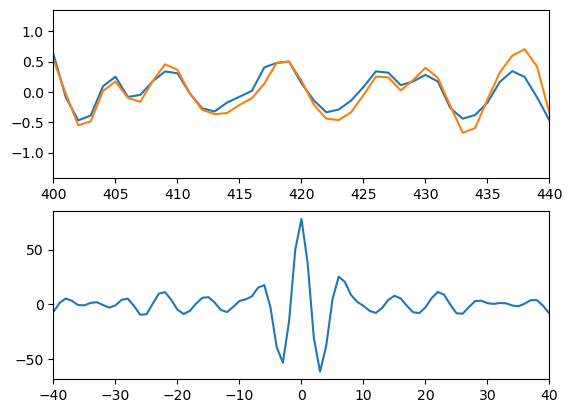

0

In [ ]:
# Tests

# check that St and Vn data are synced
clf()
subplot(2,1,1)
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)


# plot(mdv)
plot(mdv_clean_heave)
plot(mdv_clean_heavepitch)
# plot(mdv_clean_heavepitch)


plot(stare1dt, heave)
plot(stare1dt, mdv)
plot(stare1dt, mdv - heave) # subtract heave because its downward

## prepare the structure function analysis

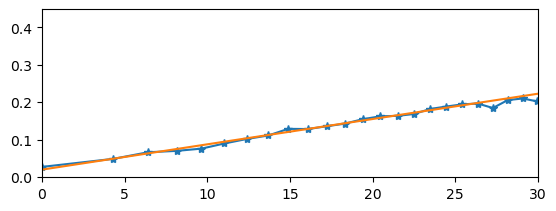

0.00012786982574739702

In [ ]:
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 30])

epsilon(A) # 1.3e-4